# Salt Tolerance Traits Simulations Notebook

This notebook runs a sensitivity analysis on the halophyte groundwater model using weather data from Agadir.

**Key Parameters:**
- Duration: Simulation length in days
- Initial soil moisture, storage volume, groundwater depth, salt concentrations
- Multiple parameter sets to explore sensitivity

**Output:**
- CSV file with model results (soil moisture, potentials, fluxes)
- Plots: soil moisture, fluxes, water potentials

In [1]:
# Import required libraries
from genericpath import exists
import os
from scipy.optimize import * 
from sympy import *
import numpy as np
import pandas as pd
from math import exp, pi, sqrt, log
import matplotlib.pyplot as plt
from dics import *
from functions import *
import importlib
import defs
importlib.reload(defs)
from defs import *
from species_traits import *
from soil_OG import Loam, DrydownSoil
#from previous_code.GWHalophyteFixingStorageEqn import *
from previous_code.GWHalophyteHR import *
import openpyxl
from datetime import date

print("Libraries imported successfully")

Libraries imported successfully


## Configuration & Parameter Setup

Define simulation parameters and sensitivity analysis ranges.

In [ ]:
today = date.today()
print("Today's date:", today)

# Simulation parameters
duration = 30  # days
weatherFile = r"sample_data\AgadirInterp30.xlsx"
resultsFolder = r'sample_output\Diagnostic_{}_GWHalophyteSSensitivityAnalysis\\'.format(today)
resultsFile = resultsFolder + 'AgadirGWHalophyte_Diagnostic_020726.csv'

# Create results folder if it doesn't exist
if not os.path.exists(resultsFolder):
    os.makedirs(resultsFolder)

# Timestep configuration
timestepM = 30  # Model timestep (minutes)
timestepD = 30  # Input data timestep (minutes)
dt = timestepM * 60.0  # Convert to seconds for differential equations

# Sensitivity analysis parameter ranges
gw_s = [150,]              # Initial groundwater salt concentration (mol/m³)
s_s = [150,]               # Initial soil salt concentration (mol/m³)
plant_s = [150,]           # Initial plant salt concentration (mol/m³)
lam_s_x = [4000,]          # Soil root length density (m/m³)
lam_gw_x = [4000,]         # Tap root length density (m/m³)

print(f"Simulation duration: {duration} days")
print(f"Results will be saved to: {resultsFile}")
print(f"Number of parameter sets: {len(gw_s)}")

Today's date: 2026-02-14
Simulation duration: 30 days
Results will be saved to: sample_output\Diagnostic_2026-02-14_GWHalophyteSSensitivityAnalysis\\AgadirGWHalophyte_Diagnostic_020726.csv
Number of parameter sets: 1


## Load Weather Data

Read weather input from Excel file (temperature, humidity, solar radiation).

In [29]:
# Load weather data from Excel
df = pd.read_excel(weatherFile, engine='openpyxl')

# Extract and convert temperature to Kelvin
tempC = df['Temperature']  # in Celsius
taInp = tempC + 273.0
taInp = list(taInp.values)

# Extract relative humidity and convert to specific humidity (kg/kg)
rh = df['Relative Humidity']  # in %
psat = A_SAT * np.exp((B_SAT * (tempC)) / (C_SAT + tempC))  # Saturated vapor pressure (Pa)
qaInp = 0.622 * rh / 100.0 * psat / P_ATM
qaInp = list(qaInp.values)

# Extract solar radiation (global horizontal irradiance)
phiInp = list(df['GHI'].values)  # W/m²

print(f"Weather data loaded: {len(taInp)} timesteps")
print(f"Temperature range: {min(tempC):.1f} - {max(tempC):.1f} °C")
print(f"Solar radiation range: {min(phiInp):.1f} - {max(phiInp):.1f} W/m²")

Weather data loaded: 17521 timesteps
Temperature range: 11.0 - 33.1 °C
Solar radiation range: 0.0 - 781.9 W/m²


## Initialize Model

Set up species, soil, atmosphere, and hydraulic components.

In [4]:
# Loop over sensitivity analysis parameter sets (typically just one for testing)
for x in range(0, 1):
        # enter values manually
        sinit = 0.5 #Initial soil moisture
        vwi = .95 #Initial storage volume
        gw_z_init = 3 #Initial depth to the groundwater table (m)
        cs_init = s_s[x] #initial salt concentration in soil, (Mol/m^3)
        cgw_init = gw_s[x] #initial salt concentration in groundwater (Mol/m^3)
        cw_init = plant_s[x] #initial salt concentration in plant storage (Mol/m^3)
        species = Pmenz() # Douglas fir, Pseudotsuga menziesii
        atmosphere = Atmosphere(phiInp[0], taInp[0], qaInp[0])
        soil = SaltySoilGW(Loam(), DrydownSoil(), species.ZR, sinit, cs_init, cgw_init, gw_z_init)
        photo = C3(species, atmosphere)
        #hydro = HalophyteGW(species, atmosphere, soil, photo, vwi, cw_init, lam_s_x[x], lam_gw_x[x]) # When using GWHalophyteFixingStorageEqn, use this line and comment out the line below
        hydro = HalophyteGW(species, atmosphere, soil, photo, vwi, cw_init) # When using GWHalophyteOsmoregulation, use this line and comment out the line above

## Run Simulation

Advance the model through each timestep using weather data.

In [5]:
    # Run simulation for each timestep
    print(f"\nRunning simulation for {duration} days...")
    n_steps = steps(duration, int(timestepM))
    plant = Simulation(species, atmosphere, soil, photo, hydro)
	
    for i in range(n_steps):
        plant.update(dt, phiInp[i], taInp[i], qaInp[i])
        
        # Progress indicator
        if (i + 1) % (n_steps // 4) == 0 or i == 0:
            print(f"  Completed {i+1}/{n_steps} timesteps ({(i+1)/n_steps*100:.1f}%)")
    
    print("Simulation complete!")
    
    # Extract results
    results = plant.output()
    
    # Save to CSV
    data = pd.DataFrame.from_dict(results)
    data.to_csv(resultsFile)
    print(f"\nResults saved to: {resultsFile}")


Running simulation for 30 days...
  Completed 1/1440 timesteps (0.1%)
  Completed 360/1440 timesteps (25.0%)
  Completed 720/1440 timesteps (50.0%)
  Completed 1080/1440 timesteps (75.0%)
  Completed 1440/1440 timesteps (100.0%)
Simulation complete!

Results saved to: sample_output\Diagnostic_2026-02-14_GWHalophyteSSensitivityAnalysis\\AgadirGWHalophyte_Diagnostic_020726.csv


## Generate Plots

Create visualizations of soil moisture, fluxes, and water potentials.

In [7]:
#Plot results
startDay = 0
endDay = duration
dispDuration = endDay-startDay
daySteps = 60//timestepM*24
timevec = np.linspace(0,duration,duration*daySteps)
timevecHr = np.linspace(0,duration*24,duration*daySteps)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

C:\Users\Josh.Gottlieb\AppData\Local\Temp\ipykernel_37148\3804420753.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


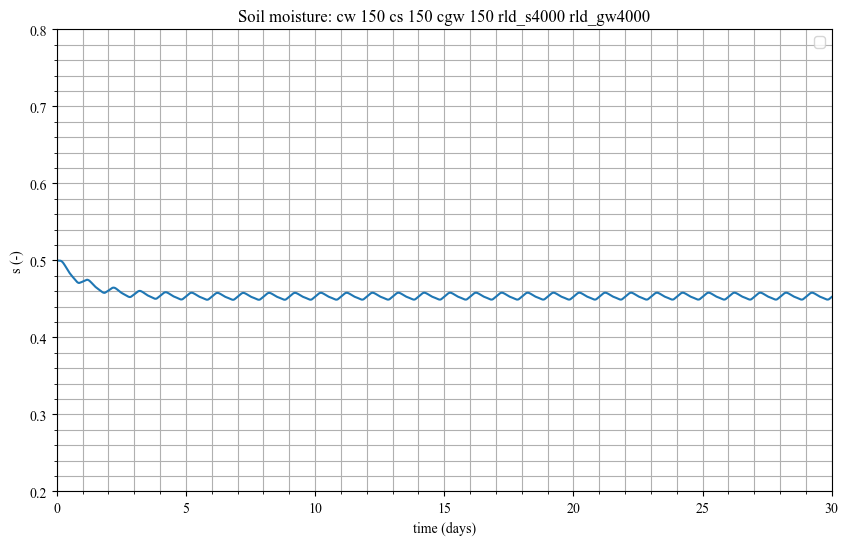

In [8]:
s = plt.figure()
gph_title = ('Soil moisture: cw {} cs {} cgw {} rld_s{} rld_gw{}'.format(plant_s[x], s_s[x], gw_s[x], lam_s_x[x], lam_gw_x[x]))
plt.title(gph_title)
plt.xlabel("time (days)")
plt.ylabel("s (-)")
plt.plot(timevec[0:daySteps*dispDuration], results['s'][daySteps*startDay:daySteps*endDay])
plt.xlim(0, dispDuration)
plt.ylim(0.2, 0.8)
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend()

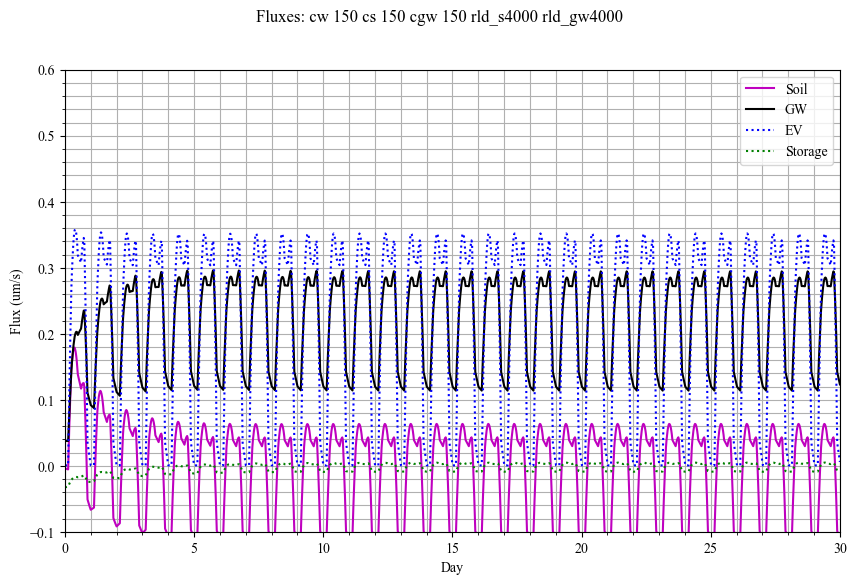

In [8]:
fluxes = plt.figure()
fluxes.suptitle('Fluxes: cw {} cs {} cgw {} rld_s{} rld_gw{}'.format(plant_s[x], s_s[x], gw_s[x], lam_s_x[x], lam_gw_x[x]))
plt.ylabel("Flux (um/s)")
plt.ylim([-0.1,0.6])
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['qs'][startDay:daySteps*endDay], 'm-', label = 'Soil')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['qgw'][startDay:daySteps*endDay], 'k-', label = 'GW')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['ev'][startDay:daySteps*endDay], 'b:', label = 'ET')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['qw'][startDay:daySteps*endDay], 'g:', label = 'Storage')
plt.xlim(0, dispDuration)
plt.xlabel("Day")
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.legend(['Soil','GW','EV','Storage'])
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')

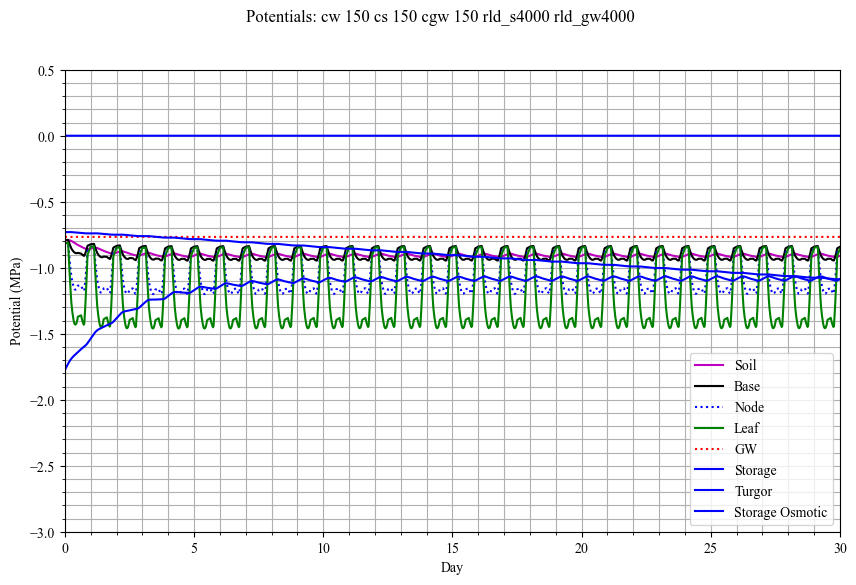

In [9]:
potents = plt.figure()
potents.suptitle('Potentials: cw {} cs {} cgw {} rld_s{} rld_gw{}'.format(plant_s[x], s_s[x], gw_s[x], lam_s_x[x], lam_gw_x[x]))
plt.ylabel('Potential (MPa)')
plt.ylim([-3,0.5])
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_s'][startDay:daySteps*endDay], 'm-', label = 'Soil')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_b'][startDay:daySteps*endDay], 'k-', label = 'Base')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_x'][startDay:daySteps*endDay], 'b:', label = 'Node')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_l'][startDay:daySteps*endDay], 'g-', label = 'Leaf')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_gw'][startDay:daySteps*endDay], 'r:', label = 'GW')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_w'][startDay:daySteps*endDay], 'b-', label = 'Storage')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_w_turgor'][startDay:daySteps*endDay], 'b-', label = 'Turgor Pressure')
plt.plot(timevec[daySteps*startDay:daySteps*endDay], results['psi_w_osm'][startDay:daySteps*endDay], 'b-', label = 'Storage Osmotic')
plt.xlim(0, dispDuration)
plt.xlabel("Day")
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.legend(['Soil','GW','EV','Storage'])
plt.legend(['Soil','Base','Node', 'Leaf', 'GW', 'Storage', 'Turgor', 'Storage Osmotic'])
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')

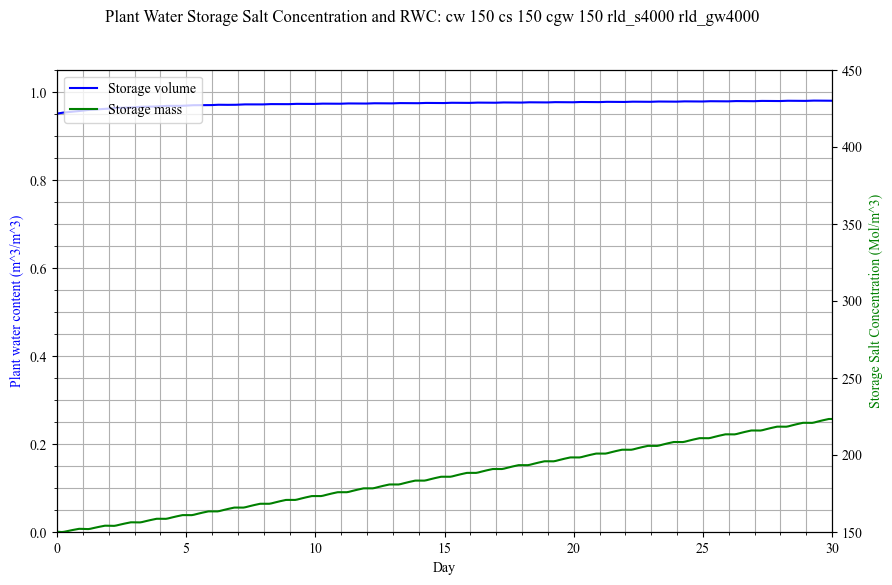

In [10]:
fig, ax1 = plt.subplots()
fig.suptitle('Plant Water Storage Salt Concentration and RWC: cw {} cs {} cgw {} rld_s{} rld_gw{}'.format(plant_s[x], s_s[x], gw_s[x], lam_s_x[x], lam_gw_x[x]))

# left axis: storage volume
ax1.plot(timevec[daySteps*startDay:daySteps*endDay], results['w'][daySteps*startDay:daySteps*endDay], 'b-', label='Storage volume')
ax1.set_ylabel('Plant water content (m^3/m^3)', color='b')
ax1.set_ylim(0, 1.05)
ax1.set_xlim(0, dispDuration)
ax1.set_xlabel('Day')
ax1.tick_params(axis='y',)

# right axis: storage mass
ax2 = ax1.twinx()
ax2.plot(timevec[daySteps*startDay:daySteps*endDay], results['cw'][daySteps*startDay:daySteps*endDay], 'g-', label='Storage mass')
ax2.set_ylabel('Storage Salt Concentration (Mol/m^3)', color='g')
ax2.set_ylim(150, 450)
ax2.tick_params(axis='y',)

# combined legend and grid/minor ticks
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
ax1.minorticks_on()
ax1.grid(visible=True, which='both', axis='both')

In [11]:
s.savefig(os.path.join(results_dir, f'SoilMoisture{plot_suffix}.png'), dpi=300, bbox_inches='tight')
fluxes.savefig(os.path.join(results_dir, f'Fluxes{plot_suffix}.png'), dpi=300, bbox_inches='tight')
potents.savefig(os.path.join(results_dir, f'Potentials{plot_suffix}.png'), dpi=300, bbox_inches='tight')

NameError: name 'results_dir' is not defined

# Refactored Simulation with Multi-Compartment Soil

This section demonstrates the use of the refactored `SoilMultiple` class with 2 compartments and the `Halophyte` hydraulic model.

**Key Features:**
- Uses `SoilMultiple` with 2 soil compartments (with salt concentrations)
- Both compartments use `DrydownSoil` dynamics and `Loam` soil type
- `Halophyte` class for hydraulic calculations with salt dynamics
- Similar parameter values to the original simulation above

In [30]:
# Import refactored classes
import importlib
import soil
import hydraulics
import defs
importlib.reload(soil)
importlib.reload(hydraulics)
importlib.reload(defs)
from soil import SoilMultiple, Loam, DrydownSoil
from hydraulics import Halophyte
from defs import SimulationMultiComp

print("Refactored classes imported successfully")

Refactored classes imported successfully


In [31]:
# Setup multi-compartment simulation parameters
# Compartment configuration (2 compartments)
num_compartments = 2
zr_arr = np.array([1.0, 1.0])  # Root zone depth for each compartment (m)
s_init_arr = np.array([0.5, 0.5])  # Initial soil moisture for each compartment
cs_init_arr = np.array([50., 50.])  # Initial salt concentration for each compartment (Mol/m³)
root_frac_arr = np.array([0.5, 0.5])  # Root fraction in each compartment (must sum to 1)
B_param = 500  # B parameter for Halophyte (can be adjusted based on soil type)
wr=0.1 # wilting point relative water content
wft=1 # full turgor relative water content
pi0 = -0.5 # osmotic potential at full turgor (MPa)
eta = 5 # Elastic modulus shape parameter for psi_wf curve
mcap = 12 # Slope of linear portion of psi_wf curve
dt = timestepM * 60.0  # Convert to seconds for differential equations

# Plant initial conditions
vwi_ref = 0.85  # Initial storage volume fraction
cw_init_ref = 150.  # Initial plant salt concentration (Mol/m³)

# Species and atmosphere setup (same as before)
species_ref = Pmenz()  # Douglas fir, Pseudotsuga menziesii
atmosphere_ref = Atmosphere(phiInp[0], taInp[0], qaInp[0])

# Create multi-compartment soil using SoilMultiple (with salt)
soil_ref = SoilMultiple(
    stype=Loam(),  # Will broadcast to both compartments
    dynamics=DrydownSoil(),  # Will broadcast to both compartments
    zr=zr_arr,
    s=s_init_arr,
    cs=cs_init_arr  # Optional parameter - passing it enables salt dynamics
)



# Create photosynthesis model
photo_ref = C3(species_ref, atmosphere_ref)

print(f"Multi-compartment soil created with {num_compartments} compartments")
print(f"Soil type: Loam")
print(f"Dynamics: DrydownSoil")
print(f"Root zone depths: {zr_arr} m")
print(f"Initial soil moisture: {s_init_arr}")
print(f"Initial salt concentrations: {cs_init_arr} Mol/m³")
print(f"Root fractions: {root_frac_arr}")
print(f"B parameter for Halophyte: {B_param}")

Multi-compartment soil created with 2 compartments
Soil type: Loam
Dynamics: DrydownSoil
Root zone depths: [1. 1.] m
Initial soil moisture: [0.5 0.5]
Initial salt concentrations: [50. 50.] Mol/m³
Root fractions: [0.5 0.5]
B parameter for Halophyte: 500


In [32]:
# Create Halophyte hydraulic model
hydro_ref = Halophyte(
    species=species_ref,
    atm=atmosphere_ref,
    soil=soil_ref,
    photo=photo_ref,
    vwi=vwi_ref,
    cw=cw_init_ref,
    s_arr=s_init_arr,
    root_frac_arr=root_frac_arr,
    B=B_param,
    cs_arr=cs_init_arr,
    wr=wr, 
    wft=wft, 
    pi0=pi0, 
    eta=eta,
    mcap=mcap,
    dt=dt
)

print("Halophyte hydraulic model initialized")
print(f"Initial plant water content: {hydro_ref.w:.3f}")
print(f"Initial plant salt concentration: {hydro_ref.cw:.1f} Mol/m³")
print(f"Initial leaf water potential: {hydro_ref.psi_l:.3f} MPa")

# Create SimulationMultiComp wrapper (similar to original Simulation class)
plant_ref = SimulationMultiComp(
    species_cls=species_ref,
    atm_cls=atmosphere_ref,
    soil_cls=soil_ref,
    photo_cls=photo_ref,
    hydro_cls=hydro_ref,
    zr_arr=zr_arr,
    root_frac_arr=root_frac_arr,
    B=B_param,

    dt=dt
)

print("\nSimulationMultiComp wrapper created successfully")

Halophyte hydraulic model initialized
Initial plant water content: 0.850
Initial plant salt concentration: 150.0 Mol/m³
Initial leaf water potential: -0.343 MPa

SimulationMultiComp wrapper created successfully


In [33]:
# Run refactored simulation using SimulationMultiComp wrapper
print(f"\nRunning refactored multi-compartment simulation for {duration} days...")
n_steps_ref = steps(duration, int(timestepM))

# Simulation loop - now simplified like the original!
for i in range(n_steps_ref):
    plant_ref.update(dt, phiInp[i], taInp[i], qaInp[i])
    
    # Progress indicator
    if (i + 1) % (n_steps_ref // 4) == 0 or i == 0:
        print(f"  Completed {i+1}/{n_steps_ref} timesteps ({(i+1)/n_steps_ref*100:.1f}%)")

print("Refactored simulation complete!")

# Extract results from plant_ref
results_ref = plant_ref.output()

print(f"\nResults extracted. Available keys: {list(results_ref.keys())}")


Running refactored multi-compartment simulation for 30 days...
  Completed 1/2880 timesteps (0.0%)
  Completed 720/2880 timesteps (25.0%)
  Completed 1440/2880 timesteps (50.0%)
  Completed 2160/2880 timesteps (75.0%)
  Completed 2880/2880 timesteps (100.0%)
Refactored simulation complete!

Results extracted. Available keys: ['a', 'psi_l', 'qs', 'gp', 'gsr', 'gsw', 'tl', 'ev', 'ev_cum', 'qw', 'vw', 'cw', 'psi_w', 'psi_w_turgor', 'psi_w_osm', 'psi_x', 'psi_b', 'gwf', 'w', 'flux_balance', 'hr_cum', 'Uptake', 'MW', 'delta psi w', 'qbx', 's', 'psi_s', 'cs']


In [34]:
print(results_ref['qs'][0])

[np.float64(0.0030822295580854283), np.float64(0.003092704571117692), np.float64(0.0030880796180925312), np.float64(0.0030834659306395325), np.float64(0.003078867186197109), np.float64(0.003074270170344467), np.float64(0.003069661623788693), np.float64(0.02791720172858712), np.float64(0.045264247614378854), np.float64(0.05728261763288733), np.float64(0.06513379301176601), np.float64(0.06967247546990898), np.float64(0.0716542598371319), np.float64(0.07202868338672022), np.float64(0.07192865428977122), np.float64(0.07139360679600323), np.float64(0.07083412743443591), np.float64(0.07045186685672507), np.float64(0.07035900434887665), np.float64(0.07059189749866811), np.float64(0.0709714217054604), np.float64(0.07154375184064005), np.float64(0.07230116625356858), np.float64(0.0731820926314958), np.float64(0.07404571774255447), np.float64(0.0733646252944619), np.float64(0.07308346059265186), np.float64(0.07294369637897635), np.float64(0.07285088747713009), np.float64(0.07277214330409594), np

In [35]:
t = 288
qs_0 = results_ref['qs'][0][t]
qs_1 = results_ref['qs'][1][t]
qw = results_ref['qw'][t]
qbx = results_ref['qbx'][t]
psi_b = results_ref['psi_b'][t]
psi_s_0 = results_ref['psi_s'][0][t]
psi_s_1 = results_ref['psi_s'][1][t]
gsr_0 = results_ref['gsr'][0][t]
gsr_1 = results_ref['gsr'][1][t]
gp = results_ref['gp'][t]
psi_l = results_ref['psi_l'][t]
psi_x = results_ref['psi_x'][t]
psi_w = results_ref['psi_w'][t]
gw = results_ref['gwf'][t]
ev = results_ref['ev'][t]

print('qs_0:',qs_0)
print('qs_1:',qs_1)
print('qw:',qw)
print('qbx:',qbx)
print('psi_b:',psi_b)
print('psi_s_0:',psi_s_0)
print('psi_s_1:',psi_s_1)
print('gsr_0:',gsr_0)
print('gsr_1:',gsr_1)
print('gp:',gp)
print('psi_l:',psi_l)
print('psi_x:',psi_x)
print('psi_w:',psi_w)
print('gw:',gw)
print('ev:',ev)

print('Balance at node B (qs sum + qbx):', qs_0 + qs_1 - qbx)
print('Balance at node X (qbx + qw - ev):', qbx + qw - ev)

qs_0: 0.002585305736807497
qs_1: 0.002585305736807497
qw: -0.004617563884530089
qbx: 0.005170611473614978
psi_b: -0.3807278402102806
psi_s_0: -0.3309778482444395
psi_s_1: -0.3309778482444395
gsr_0: 0.05193539648577571
gsr_1: 0.05193539648577571
gp: 0.05394163436096603
psi_l: -0.38703526388452225
psi_x: -0.38643353482119136
psi_w: -0.6110701731887205
gw: 0.0024471074275751463
ev: 0.0005452985851918513
Balance at node B (qs sum + qbx): 1.5612511283791264e-17
Balance at node X (qbx + qw - ev): 7.749003893038164e-06


In [36]:
print(np.array(results_ref['flux_balance']).mean())
node_x_bal_array = ((np.array(results_ref['qbx'])+np.array(results_ref['qw'])-np.array(results_ref['ev'])))


-0.00014127143602035965


## Plots for Refactored Simulation

In [37]:
#Plot results
startDay = 0
endDay = duration
dispDuration = endDay-startDay
daySteps = 60//timestepM*24
timevec = np.linspace(0,duration,duration*daySteps)
timevecHr = np.linspace(0,duration*24,duration*daySteps)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

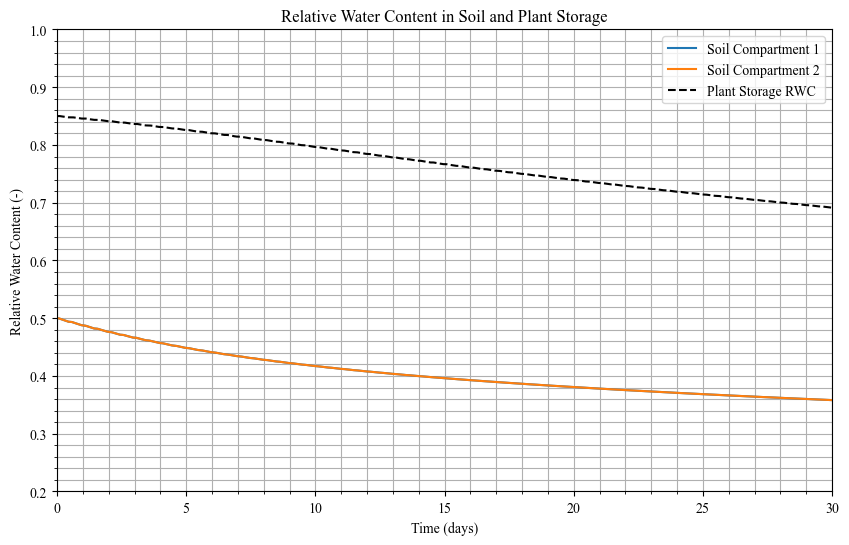

In [38]:
# Soil Moisture and Storage RWC Plot for Multi-Compartment System
s_ref = plt.figure(figsize=(10, 6))
plt.title('Relative Water Content in Soil and Plant Storage')
plt.xlabel("Time (days)")
plt.ylabel("Relative Water Content (-)")

# Plot each compartment
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], results_ref['s'][j][0:daySteps*dispDuration], 
             label=f'Soil Compartment {j+1}')
plt.plot(timevec[0:daySteps*dispDuration], results_ref['w'][0:daySteps*dispDuration], 'k--', label='Plant Storage RWC')

plt.xlim(0, dispDuration)
plt.ylim(0.2, 1)
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.show()

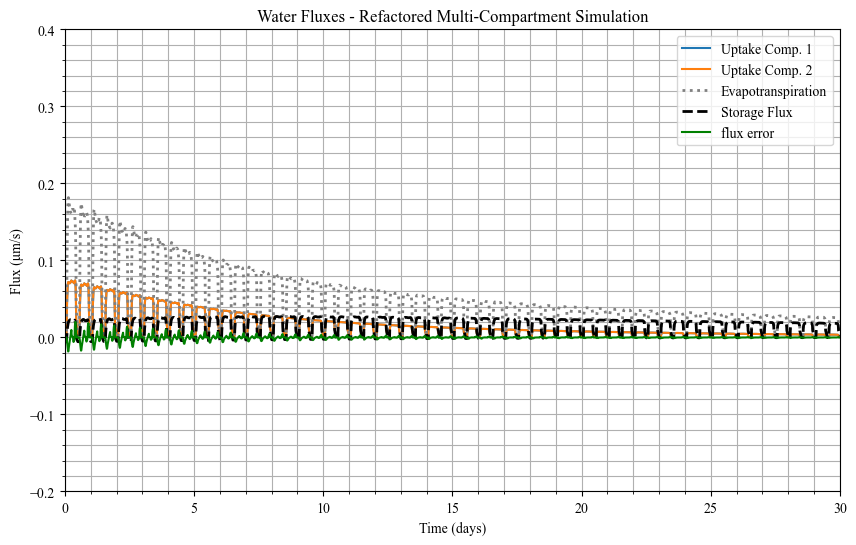

In [39]:
# Fluxes Plot for Multi-Compartment System
fluxes_ref = plt.figure(figsize=(10, 6))
plt.title('Water Fluxes - Refactored Multi-Compartment Simulation')
plt.ylabel("Flux (μm/s)")
plt.xlabel("Time (days)")

# Plot water uptake from each compartment
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], results_ref['qs'][j][0:daySteps*dispDuration], 
             label=f'Uptake Comp. {j+1}')

# Plot evapotranspiration
plt.plot(timevec[0:daySteps*dispDuration], results_ref['ev'][0:daySteps*dispDuration], 
         c='grey', linestyle=':', linewidth=2, label='Evapotranspiration')
# Plot evapotranspiration
plt.plot(timevec[0:daySteps*dispDuration], results_ref['qw'][0:daySteps*dispDuration], 
         c='k', linestyle='--', linewidth=2, label='Storage Flux')
plt.plot(timevec[0:daySteps*dispDuration],node_x_bal_array,c='g',label="flux error")

plt.xlim(0, dispDuration)
#plt.xlim(0,1)
plt.ylim([-0.2, 0.40])
plt.xticks(np.arange(0, dispDuration+1, 5))
#plt.xticks(np.arange(0, 1.1, 0.2))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.show()

In [40]:
np.array(results_ref['psi_w']).max()

np.float64(-0.5998945226425915)

C:\Users\Josh.Gottlieb\AppData\Local\Temp\ipykernel_28008\2194331233.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_x'][0:daySteps*dispDuration],


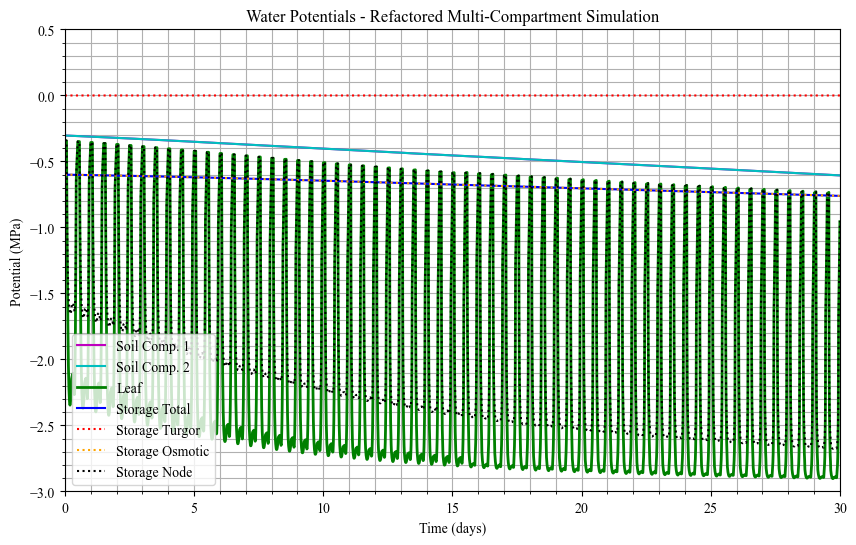

In [41]:
# Water Potentials Plot for Multi-Compartment System
potents_ref = plt.figure(figsize=(10, 6))
plt.title('Water Potentials - Refactored Multi-Compartment Simulation')
plt.ylabel('Potential (MPa)')
plt.xlabel("Time (days)")

# Plot soil water potential for each compartment
colors_soil = ['m-', 'c-']
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_s'][j][0:daySteps*dispDuration], 
             colors_soil[j], label=f'Soil Comp. {j+1}')

# Plot leaf water potential
plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_l'][0:daySteps*dispDuration], 
         'g-', linewidth=2, label='Leaf')

# Plot plant storage potentials
plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_w'][0:daySteps*dispDuration], 
         'b-', label='Storage Total')
plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_w_turgor'][0:daySteps*dispDuration], 
         'r:', label='Storage Turgor')
plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_w_osm'][0:daySteps*dispDuration], 
         'orange', linestyle=':', label='Storage Osmotic')
plt.plot(timevec[0:daySteps*dispDuration], results_ref['psi_x'][0:daySteps*dispDuration], 
         'k--', linestyle=':', label='Storage Node')

plt.xlim(0, dispDuration)
plt.ylim([-3, 0.5])
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend(loc='lower left')
plt.show()

[]

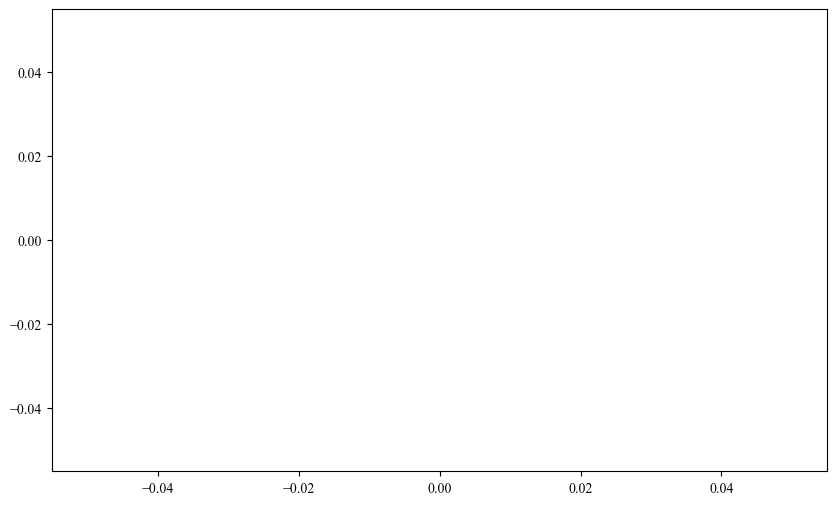

In [38]:
plt.plot()

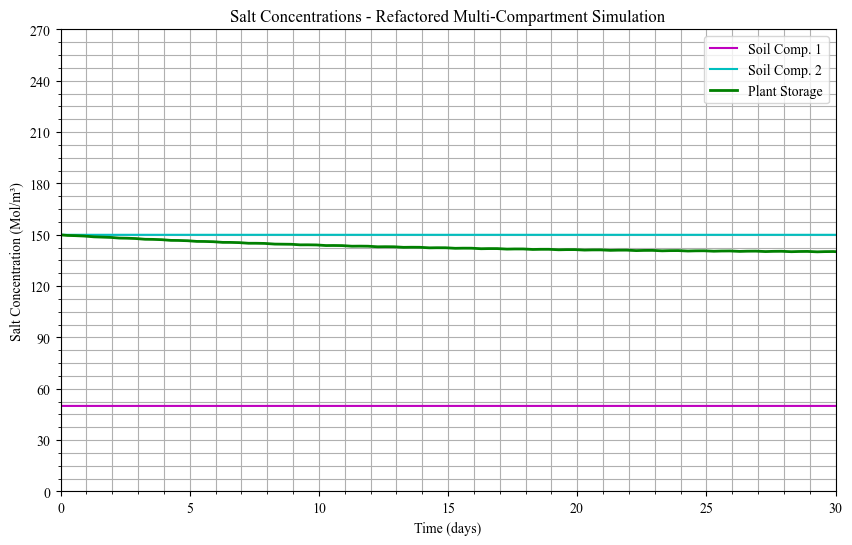

In [15]:
# Salt Concentrations Plot for Multi-Compartment System
salt_ref = plt.figure(figsize=(10, 6))
plt.title('Salt Concentrations - Refactored Multi-Compartment Simulation')
plt.ylabel('Salt Concentration (Mol/m³)')
plt.xlabel("Time (days)")

# Plot soil salt concentration for each compartment
colors_salt = ['m-', 'c-']
for j in range(num_compartments):
    plt.plot(timevec[0:daySteps*dispDuration], results_ref['cs'][j][0:daySteps*dispDuration], 
             colors_salt[j], label=f'Soil Comp. {j+1}')

# Plot plant storage salt concentration
plt.plot(timevec[0:daySteps*dispDuration], results_ref['cw'][0:daySteps*dispDuration], 
         'g-', linewidth=2, label='Plant Storage')

plt.xlim(0, dispDuration)
plt.xticks(np.arange(0, dispDuration+1, 5))
plt.yticks(np.arange(0,300,30))
plt.minorticks_on()
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.show()

In [ ]:
# Plant Water Storage and Salt Concentration with Dual Axes
fig_ref, ax1_ref = plt.subplots(figsize=(10, 6))
fig_ref.suptitle('Plant Water Storage and Salt Concentration - Refactored Simulation')

# Left axis: Plant water content (w)
ax1_ref.plot(timevec[0:daySteps*dispDuration], results_ref['w'][0:daySteps*dispDuration], 
             'b-', linewidth=2, label='Plant Water Content')
ax1_ref.set_ylabel('Plant Water Content (m³/m³)', color='b')
ax1_ref.set_ylim(0, 1.05)
ax1_ref.set_xlim(0, dispDuration)
ax1_ref.set_xlabel('Time (days)')
ax1_ref.tick_params(axis='y', labelcolor='b')

# Right axis: Plant salt concentration (cw)
ax2_ref = ax1_ref.twinx()
ax2_ref.plot(timevec[0:daySteps*dispDuration], results_ref['cw'][0:daySteps*dispDuration], 
             'g-', linewidth=2, label='Plant Salt Concentration')
ax2_ref.set_ylabel('Plant Salt Concentration (Mol/m³)', color='g')
ax2_ref.tick_params(axis='y', labelcolor='g')

# Combined legend
lines_ref = ax1_ref.get_lines() + ax2_ref.get_lines()
labels_ref = [l.get_label() for l in lines_ref]
ax1_ref.legend(lines_ref, labels_ref, loc='upper right')
ax1_ref.minorticks_on()
ax1_ref.grid(visible=True, which='both', axis='both')
ax1_ref.set_xticks(np.arange(0, dispDuration+1, 5))
plt.show()